# Investigation of other maritime disasters

The sinking of the RMS Titanic went down in history as an unprecedented maritime disaster. But is that really the case? What were the maritime disasters in the centuries before and after?

To analyze these questions, maritime disasters from the 18th, 19th, 20th and 21st centuries are compared. All the disasters are not related to a battle in order to be comparable to the case of the Titanic.

In [191]:
# Import libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn theme
sns.set_style("whitegrid")

In [192]:
# Source URLs to the Wikipedia articles
url_18th = "https://en.wikipedia.org/wiki/List_of_maritime_disasters_in_the_18th_century"
url_19th = "https://en.wikipedia.org/wiki/List_of_maritime_disasters_in_the_19th_century"
url_20th = "https://en.wikipedia.org/wiki/List_of_maritime_disasters_in_the_20th_century"
url_21st = "https://en.wikipedia.org/wiki/List_of_maritime_disasters_in_the_21st_century"

In [193]:
# Define function for table extraction from Wikipedia
def table_extractor(url: str):
  """
  Extracts wikipedia tables from Wikipedia pages of maritime disasters.

  Returns: Dataframe

  Args: - url: url for Wikipedia page
  """

  response = requests.get(url)
  parsed_html = BeautifulSoup(response.text, "html.parser")
  table = parsed_html.find("table", {"class": "wikitable"})

  # Wrap the HTML string in a StringIO object for future compatibility with pd.read_html
  table_html = StringIO(str(table))

  return pd.read_html(table_html)[0]

In [194]:
# Fetch data from Wikipedia
df_18th = table_extractor(url_18th)
df_19th = table_extractor(url_19th)
df_20th = table_extractor(url_20th)
df_21st = table_extractor(url_21st)

# Concatenate dataframes
df = pd.concat([df_18th, df_19th, df_20th, df_21st], axis=0)

# Remove image column and rename other columns to lowercase
df = df.drop("Image", axis=1)
df = df.rename(columns={"Year": "year", "Country": "country",
                        "Description": "description", "Deaths": "deaths"})

# Show dataframe
df.head()

,year,country,description,deaths
0,1782,Great Britain,1782 Central Atlantic hurricane – On 17 Septem...,3500
1,1703,England,The Channel Storm – In November a great storm ...,"1,500+"
2,1707,Great Britain,The Scilly naval disaster of 1707 – On 22 Octo...,"1,400–2,000"
3,1744,Great Britain,HMS Victory – The 100-gun first-rate sank in a...,1150
4,1760,Great Britain,"HMS Ramillies – the second-rate, formerly HMS ...",829


The "deaths" column contains strings in various formats. For clarity, the strings are converted to the first number (e.g. in "1,547 (known) 1,800 (estimated)", 1547 is assigned as the number of deaths). For ranges (e.g. "1,400-2,000") the median is taken.

In [195]:
# Remove unwanted characters from the death column and return revised list

def death_col_transformation(df: pd.DataFrame) -> pd.DataFrame:
  """
  Removes various characters found in the "deaths" column. If a range is given,
  the median will be returned.

  Returns a dataframe with the "deaths" column replaced

  Args: - Dataframe to transform
  """

  # Loop over entries in death column
  fixed_list = []
  for entry in df["deaths"]:
    death = entry.replace("+", "")
    death = death.replace("c. ", "")
    death = death.replace(",", "")
    death = death.replace("≈ ", "")
    death = death.replace("~", "")
    death = death.split(" ")[0]
    death = death.split("[")[0]

    # If a range is given return the median, 2 different - chars
    if "–" in death:
      a = int(death.split("–")[0])
      b = int(death.split("–")[-1])
      death = np.mean([a, b])
    elif "-" in death:
      a = int(death.split("-")[0])
      b = int(death.split("-")[-1])
      death = np.mean([a, b])

    # Cast entries to integers and append to list
    fixed_list.append(int(death))
  # Replace deaths with fixed values
  df["deaths"] = fixed_list
  return df

In [196]:
# Transform death column
df = death_col_transformation(df)

## How does the sinking of the Titanic compare to other maritime disasters of the same generation (1912 $\pm$ 15 years)?

In [197]:
# Extract data from 1897 to 1927
lower_year = 1897
upper_year = 1927
df_titanic_period = df.copy()
df_titanic_period = df_titanic_period.query("@lower_year <= year <= @upper_year")

**To which countries did the ships involved in the accident belong?**

country
United States     16
United Kingdom    16
France             5
Canada             4
Japan              3
Spain              2
Name: count, dtype: int64


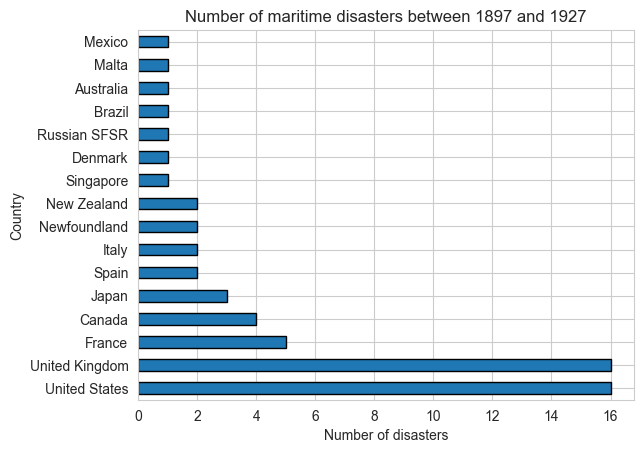

In [198]:
# Plot histogram of countries
print(df_titanic_period["country"].value_counts()[:6])
ax = df_titanic_period["country"].value_counts().plot(kind="barh", edgecolor="k")
ax.set_title(f"Number of maritime disasters between {lower_year} and {upper_year}")
ax.set_ylabel("Country")
ax.set_xlabel("Number of disasters")
plt.show()

Between 1897 and 1927, the largest number of maritime disasters occurred under the flags of the United Kingdom (16) and the United States (16), followed by France, Canada, and Japan with 5, 4, and 3 incidents, respectively.

**What is the distribution of casualties across the dataset?**

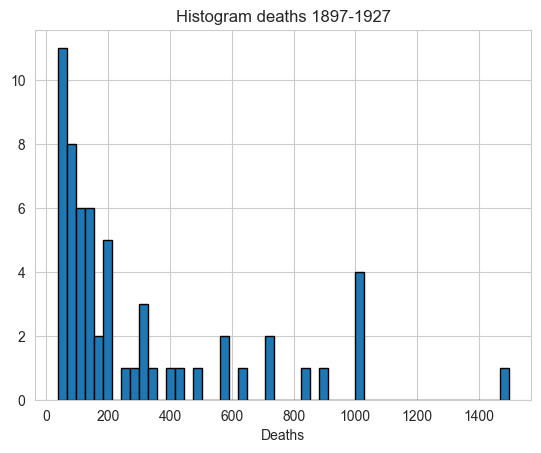

In [199]:
# Plot histogram of deaths
df_titanic_period["deaths"].hist(bins=50, edgecolor="k")
plt.title(f"Histogram deaths {lower_year}-{upper_year}")
plt.xlabel("Deaths")
plt.show()

In [200]:
# View statistics for the specified period
df_titanic_period["deaths"].describe()

count      59.000000
mean      300.389831
std       330.395219
min        37.000000
25%        87.000000
50%       149.000000
75%       369.500000
max      1496.000000
Name: deaths, dtype: float64

* The majority of marine disasters had fewer than 200 casualties
* A few larger events with more casualties occurred
* Majority of marine disasters had fewer than 149 casualties
* Large range between minimum and maximum 
* The sinking of the Titanic, with 1496 fatalities, is the largest disaster of the period

In [201]:
# Query for events with at least 1000 deaths
df_titanic_period.query("deaths >= 1000")

,year,country,description,deaths
3,1912,United Kingdom,"RMS Titanic – A British ocean liner and, at th...",1496
5,1914,Canada,RMS Empress of Ireland – On 29 May the passeng...,1012
6,1904,United States,General Slocum – The paddle steamer caught fir...,1029
7,1912,Japan,Kiche Maru – Sank in a typhoon in the Pacific ...,1000
8,1921,Singapore,"Hong Moh – On 3 March, the ship struck the Whi...",1000


The next fatal maritime disasters, between 1897 and 1927, each claimed about 1000 lives and were 67-69% the size of the Titianic sinking.

### Conclusions:

1. Titanic was indeed the worst disaster of it's time.
2. The vast majority of disasters occurred under US and British flags, which may correspond to the extensive shipping of both nations.
3. The average number of casualties was 300 +/- 333, with a median of 149, a minimum of 37, and a maximum of 1496.

## How does the sinking of the Titanic compare to other maritime disasters from the 18th century to the present, and how have such events changed over time?

In [202]:
# Copy dataframe
df_complete = df.copy()

# Set lower and upper year
lower_year = df_complete["year"].min()
upper_year = df_complete["year"].max()

# Add new column for the centuries
df_complete["century"] = df_complete["year"] // 100 + 1

# Check statistics of centuries
df_complete[["deaths", "century"]].groupby("century").agg(["count", "mean", "std", "median", "min", "max"])

deaths                                         
         count        mean         std median min   max
century                                                
18          33  515.575758  662.490520  269.0  86  3500
19         137  283.423358  242.899117  220.0  14  1600
20         158  272.170886  445.881581  128.5  20  4386
21          98  152.540816  267.150993   53.5   2  1864

* Data points for the 18th century are very limited
* Mean and median decrease successively from 18th to 21st century
* Standard deviation is very high for all centuries

country
United Kingdom    92
United States     83
Great Britain     19
Philippines       16
Bangladesh        14
Indonesia         12
Name: count, dtype: int64


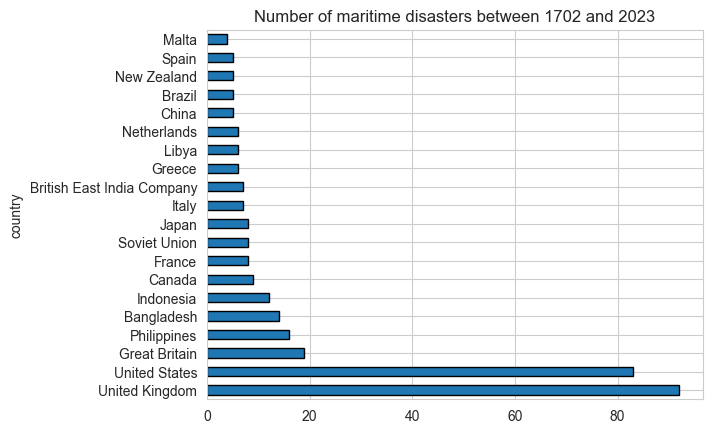

In [203]:
# Plot histogram of countries
print(df_complete["country"].value_counts()[:6])
df_complete["country"].value_counts()[:20].plot(kind="barh", edgecolor="k")
plt.title(f"Number of maritime disasters between {lower_year} and {upper_year}")
ax.set_ylabel("Country")
ax.set_xlabel("Number of disasters")
plt.show()

* The United Kingdom had the most maritime disasters, especially since "United Kingdom" and "Great Britain" basically refer to the same country
* Number 2 is the USA, followed by South Asian countries

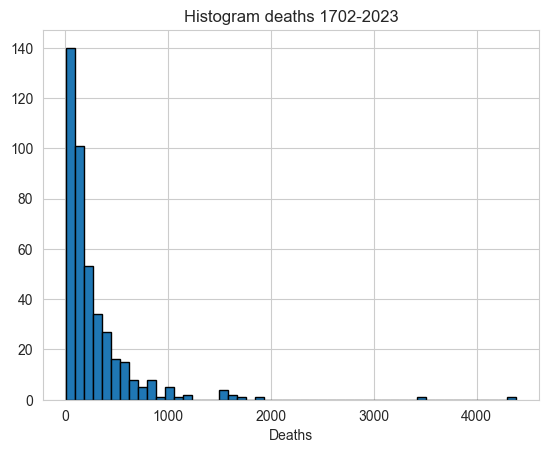

In [204]:
# Plot histogram of deaths
df_complete["deaths"].hist(bins=50, edgecolor="k")
plt.title(f"Histogram deaths {lower_year}-{upper_year}")
plt.xlabel("Deaths")
plt.show()

* The distribution for the period from the 18th century to the present is very similar to that examined for the Titanic period. Large disasters with a few thousand victims are still very rare

In [205]:
# Query for events with at least 1000 deaths
large_disasters = df_complete.query("deaths >= 1000").sort_values("deaths", ascending=False).reset_index(drop=True)
number_large_disasters = len(large_disasters)
all_disasters = len(df_complete)
print(f"Rate of large disasters with >= 1000 deaths {100 * number_large_disasters / all_disasters:.2f}%")
large_disasters

Rate of large disasters with >= 1000 deaths 4.23%


,year,country,description,deaths,century
0,1987,Philippines,"Doña Paz – Late on 20 December, while bound fo...",4386,20
1,1782,Great Britain,1782 Central Atlantic hurricane – On 17 Septem...,3500,18
2,2002,Senegal,"Le Joola – On 26 September, the overloaded fer...",1864,21
3,1707,Great Britain,The Scilly naval disaster of 1707 – On 22 Octo...,1700,18
4,1822,China,Tek Sing – The Chinese junk was bound for Bata...,1600,19
5,1991,Egypt,Salem Express – At midnight between 14–15 Dece...,1600,20
6,1865,United States,Sultana – On 27 April this Mississippi riverbo...,1547,19
7,1703,England,The Channel Storm – In November a great storm ...,1500,18
8,1993,Haiti,Ferry Neptune – Sank on 16 February.[8][9][10],1500,20
9,1912,United Kingdom,"RMS Titanic – A British ocean liner and, at th...",1496,20


* In fact, large disasters with more than 1000 victims account for 4.2% of all maritime disasters in the dataset.

In [206]:
# Calculate number of casualties for large disasters compared to the total number of casualties
large_death = large_disasters["deaths"].sum()
overall_death = df_complete["deaths"].sum()
print(f"Number of casualties for large disasters compared to the total number of casualties: {100 * large_death / overall_death:.2f}%")
print(f"Number of casualties for Titanic disaster compared to the total number of casualties: {100 * 1496 / overall_death:.2f}%")
print(f"Number of casualties for Titanic disaster compared to the total number of casualties: {100 * 1496 / overall_death:.2f}%")

Number of casualties for large disasters compared to the total number of casualties: 25.60%
Number of casualties for Titanic disaster compared to the total number of casualties: 1.31%
Number of casualties for Titanic disaster compared to the total number of casualties: 1.31%


* But these few large disasters account for about a quarter of all deaths in the dataset
* The sinking of the Titanic accounts for 1.3% of all peacetime deaths from maritime disasters between the 18th century and the present

## What if the Titanic had sunk with its full capacity of 3,547 people on board?

In [207]:
# Calculate fatalities as total passengers * 61.6% fatality rate and add entry to dataframe
titanic_full_deaths = int(3547 * 0.616)
titanic_hypothetical = pd.DataFrame([[1912, "United Kingdom", "Hypothetical fully loaded Titanic", titanic_full_deaths, 20]], columns=df_complete.columns)
df_complete = pd.concat([df_complete, titanic_hypothetical])

In [208]:
# Query for entries with at least 1000 deaths and sort for deaths
df_complete.query("deaths >= 1000").sort_values("deaths", ascending=False).reset_index(drop=True)

,year,country,description,deaths,century
0,1987,Philippines,"Doña Paz – Late on 20 December, while bound fo...",4386,20
1,1782,Great Britain,1782 Central Atlantic hurricane – On 17 Septem...,3500,18
2,1912,United Kingdom,Hypothetical fully loaded Titanic,2184,20
3,2002,Senegal,"Le Joola – On 26 September, the overloaded fer...",1864,21
4,1707,Great Britain,The Scilly naval disaster of 1707 – On 22 Octo...,1700,18
5,1822,China,Tek Sing – The Chinese junk was bound for Bata...,1600,19
6,1991,Egypt,Salem Express – At midnight between 14–15 Dece...,1600,20
7,1865,United States,Sultana – On 27 April this Mississippi riverbo...,1547,19
8,1993,Haiti,Ferry Neptune – Sank on 16 February.[8][9][10],1500,20
9,1703,England,The Channel Storm – In November a great storm ...,1500,18


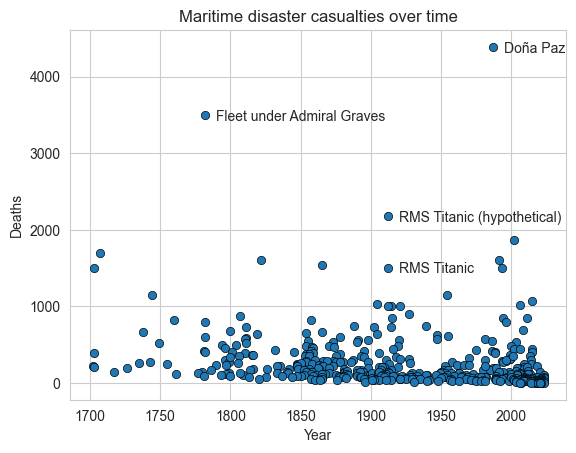

In [209]:
# Plot number of deaths versus year
ax = sns.scatterplot(data=df_complete, x="year", y="deaths", edgecolor="k")
ax.set_xlabel("Year")
ax.set_ylabel("Deaths")
ax.set_title("Maritime disaster casualties over time")
ax.text(x=1995, y=4315, s="Doña Paz")
ax.text(x=1790, y=3425, s="Fleet under Admiral Graves")
ax.text(x=1920, y=1435, s="RMS Titanic")
ax.text(x=1920, y=2100, s="RMS Titanic (hypothetical)")
plt.show()

**Conclusions:** If the Titanic had been sunk with its full capacity of 3,547 people on board and the reported survival rate of 38.4%:

* It's sinking would have been the third largest maritime disaster of the period considered
* It would have been the largest maritime disaster involving only one ship